# Prototype 2 Concept Notebook
J. Cristiano

for a days worth of images.       
    * get sam2 embeddings for all images    
    * select a good sample and a bad sample     
    * cosine similarity filtering      
    * fewshot Sam2      
    * process     

In [1]:
#Imports & Setup
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
from PIL import Image
import glob
import time
from tqdm import tqdm
import pickle

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [2]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/opt/sam2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [3]:
#Load the files
image_path_list = glob.glob('/work/pogo24/*/*.jpg')
image_list = [cv2.resize(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), (512, 512))[150:406,150:406,:] for image_path in image_path_list]

In [4]:
print(f"Loaded {len(image_list)} images")

Loaded 348 images


In [5]:
embeddings_file = 'embeddings.pkl'
if os.path.exists(embeddings_file):
    with open(embeddings_file, 'rb') as f:
        all_embeddings = pickle.load(f)
else:
    all_embeddings = []
    start = time.time()
    batch_size = 10
    for i in tqdm(range(0, len(image_list), batch_size), desc="Processing images"):
        predictor.set_image_batch(image_list[i:i+batch_size])
        list_of_embeddings = predictor.get_image_embedding()
        list_embedding_reshaped = list_of_embeddings[:].view(list_of_embeddings[:].size(0), -1)
        all_embeddings.append(list_embedding_reshaped.cpu())
    with open('embeddings.pkl', 'wb') as file:
        pickle.dump(all_embeddings, file)
    end = time.time()
    print(f"Generating and storing embeddings took: {(end-start):.2f} sec")

Processing images: 100%|████████████████████████████████████████| 35/35 [15:10<00:00, 26.02s/it]


Generating and storing embeddings took: 912.13 sec


In [7]:
all_embeddings_flattened = [embedding.view(embedding.size(0), -1) for embedding in all_embeddings]
all_embeddings_np = np.vstack([embedding.numpy() for embedding in all_embeddings_flattened])

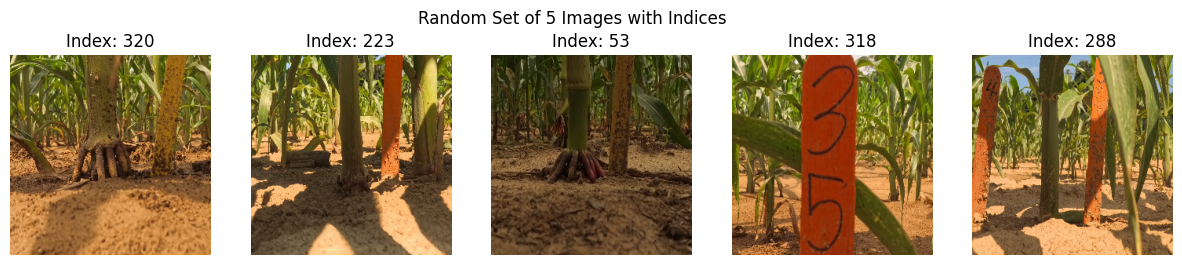

In [8]:
import random

# Select 5 random indices from the image_list
random_indices = random.sample(range(len(image_list)), 5)

# Plot the randomly selected images with their indices as labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, index in enumerate(random_indices):
    axes[i].imshow(image_list[index])
    axes[i].axis('off')
    axes[i].set_title(f'Index: {index}')
plt.suptitle('Random Set of 5 Images with Indices')
plt.show()

In [9]:
def normalize(vec: np.ndarray):
    if vec.ndim == 1:
        return vec / np.linalg.norm(vec)
    return vec / np.linalg.norm(vec, axis=1, keepdims=True)
all_embeddings_np_norm = [normalize(emb) for emb in all_embeddings_np]
#manually select a good and bad sample from the list
good_sample = all_embeddings_np_norm[53]
bad_sample = all_embeddings_np_norm[318]

In [10]:
def extract_features(good,bad,big_list):
    ret = []
    for img_embedding in big_list:
        x = np.dot(good,img_embedding.T)
        y = np.dot(bad, img_embedding.T)
        ret.append((x,y))
    return ret

cos_similarity_space = extract_features(good_sample, bad_sample, all_embeddings_np_norm)

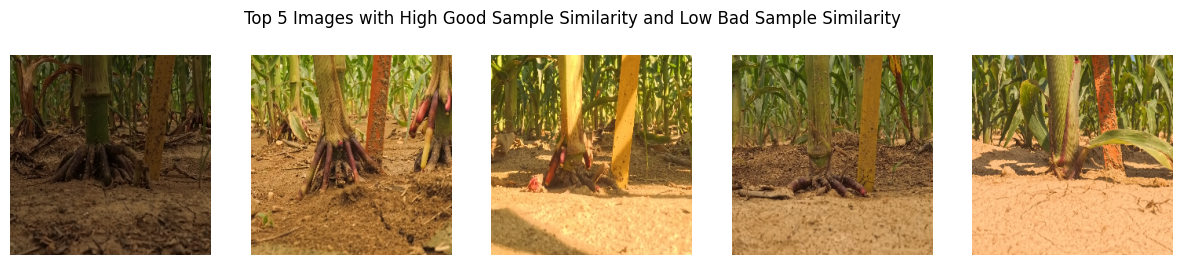

In [11]:
# Combine the indices with the similarity scores
indexed_cos_similarity_space = list(enumerate(cos_similarity_space))

# Sort by good sample similarity (descending) and bad sample similarity (ascending)
sorted_cos_similarity_space = sorted(indexed_cos_similarity_space, key=lambda x: (-x[1][0], x[1][1]))
# Filter sorted_cos_similarity_space for all entries where x[1][0] > x[1][1]
filtered_cos_sim_space = [x for x in sorted_cos_similarity_space if x[1][0] > x[1][1]]

# Select the top 5 images
# top_5_indices = [index for index, _ in sorted_cos_similarity_space[5:10]]
top_5_indices = [index for index, _ in filtered_cos_sim_space[20:25]]
# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, index in enumerate(top_5_indices):
    axes[i].imshow(image_list[index])
    axes[i].axis('off')
plt.suptitle('Top 5 Images with High Good Sample Similarity and Low Bad Sample Similarity')
plt.show()

In [12]:
from sam2.build_sam import build_sam2_video_predictor
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [13]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [14]:
import tempfile

# Create a temporary directory
temp_dir = tempfile.mkdtemp()
for i, (index, _) in enumerate(filtered_cos_sim_space):
    image_path = os.path.join(temp_dir, f'{i}.jpg')
    cv2.imwrite(image_path, cv2.cvtColor(image_list[index], cv2.COLOR_RGB2BGR))
print(f"Images saved to temporary directory: {temp_dir}")


Images saved to temporary directory: /tmp/tmpa5wydot6


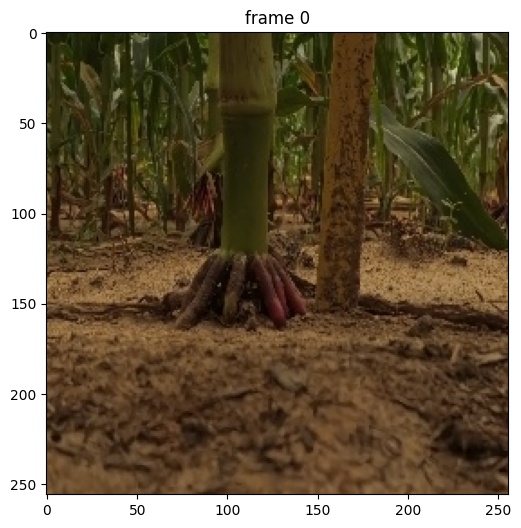

In [15]:
frame_names = [p for p in os.listdir(temp_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(temp_dir, frame_names[frame_idx])))

In [16]:
inference_state = predictor.init_state(video_path=temp_dir)

frame loading (JPEG): 100%|███████████████████████████████████| 334/334 [00:03<00:00, 90.36it/s]


In [30]:
predictor.reset_state(inference_state)

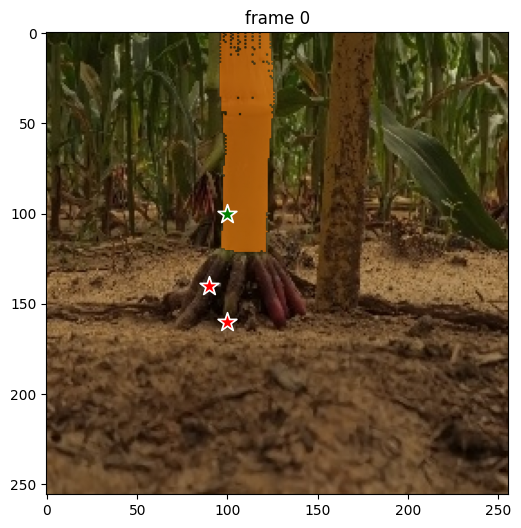

In [31]:
#adding annotations for stalks
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[100, 100],[100, 160],[90,140]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 0, 0], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(temp_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])



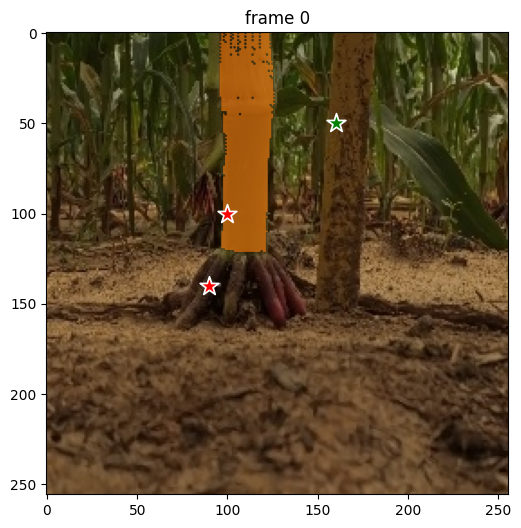

In [32]:
#adding annotations for markers
ann_frame_idx = 0 # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[160, 50],[100,100],[90,140]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,0,0], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(temp_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

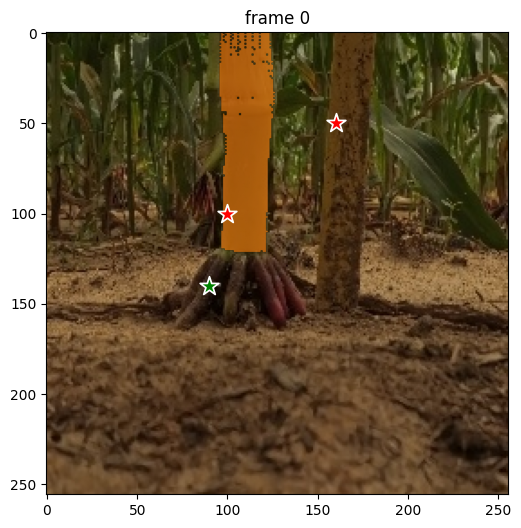

In [33]:
#annotating roots
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[90,140],[100, 100],[160,50]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,0,0], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(temp_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|█████████████████████████████████████| 334/334 [03:23<00:00,  1.64it/s]


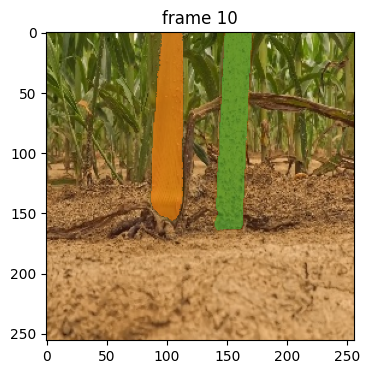

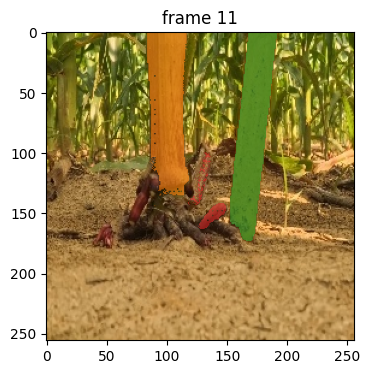

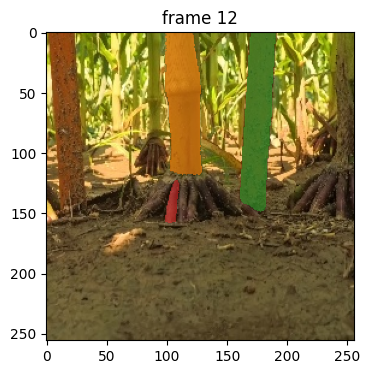

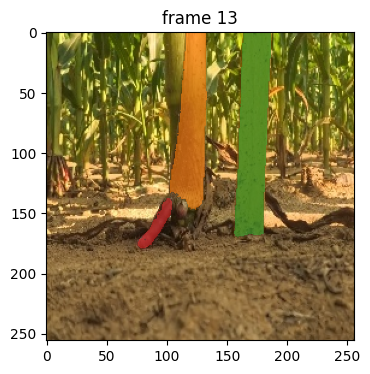

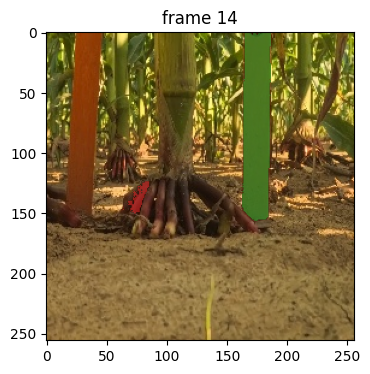

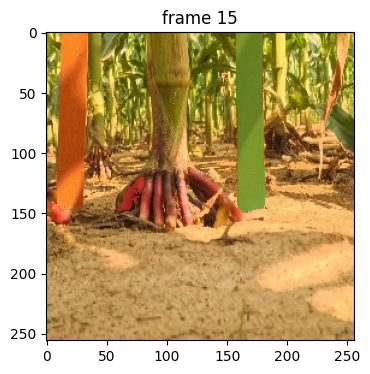

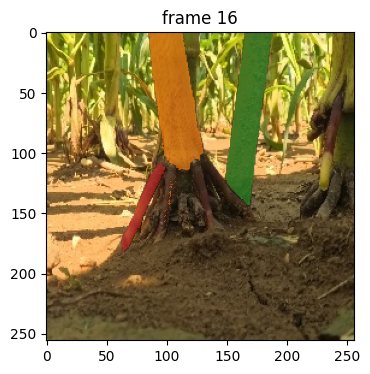

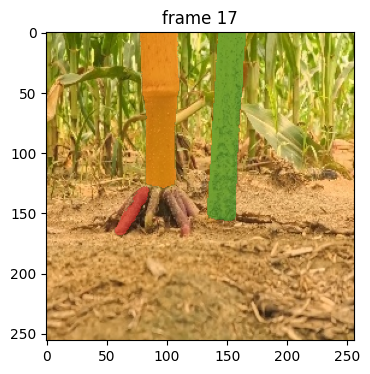

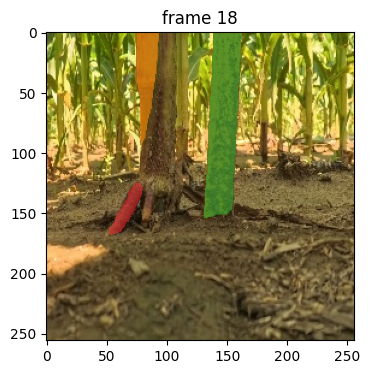

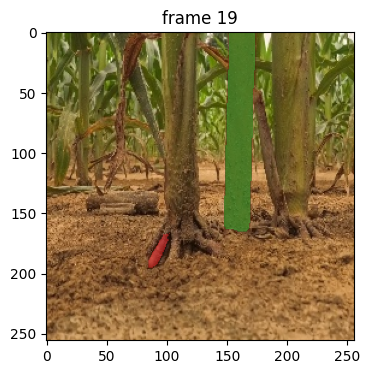

In [34]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(10, 20, vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(temp_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
